In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

In [2]:
E42_E1C_PRN_string = '9C6674915677A62A7AFD4FCB27B45F8E6DDDD08980B7DBE1131E6E2425C5ADBEE8474E93A8A2D4E495B195A6B83F2CF6472A36E690928362B9A1FA994A9FEB7BCBA7FDCB771F59FB434ED289CCEABDAFAE29113389EB98D6F17E5508D5976E11BC8A1E93AF9F7B1C81686265930B4D334568E3F29E1C2F58A62572A610016C1C1C1C9E1D0EB3FEB2B3A210C59EB3980C44BC656FA7C5E05A4472D4255B40B8A1604FE39D8B5026A976310648D5C84CEBC87A8BF6545DC843A3A0B64DC4CCAF2D2203122DDD75BA42E096844899A35A899FDFD72C26E3392EA03351DC78BB9F62F51D913F8008DB00969C64003773FB2014FAF97E794A45792495BD52D7BE7ACA47FF2BF570CF88303377092B5B6BFF3B01D38A53E8A68B0D81FC2D1D375EB27C7AEEDD70679E8DDBA6DE656442ED951478FB96A979B4A9091F344EF39AF23DAA886C6FBAA8611C61686332C630690109E2869D18EE7A2C21B22921B9E3DE40BF063E370FF64E7AFE160B7EBFC4AF6AEDA043042552F5F36C2CABD339FE1442242EAD931D1B83968D1A31A7E32A0838401DBB9C1034D56ADCAF5942462EF63440FD70F91520137A50372D0D125A6285F7D715FD9225D03A109E1FC5EB547303CD7708F88FEED2814607171930436B249924714E8D8E024C24B3C0C9E40127DECE1AD966C3F9DF01793864615F291B73F73D27B624ACBEAD3D371B8D4FDA823C0'
primary_code = 1 - 2*np.unpackbits(np.frombuffer(bytes.fromhex(E42_E1C_PRN_string + '0'), dtype = 'uint8'))[:4092].astype('int')
secondary_code = 1 - 2*np.array([0,0,1,1,1,0,0,0,0,0,0,0,1,0,1,0,1,1,0,1,1,0,0,1,0])
prn = np.tile(primary_code, secondary_code.size) * np.repeat(secondary_code, primary_code.size)

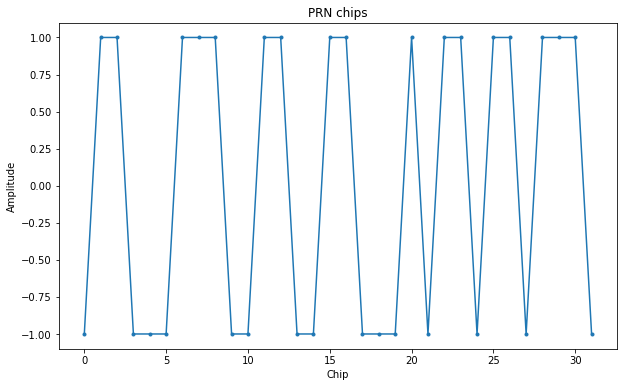

In [3]:
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(prn[:32], '.-')
plt.title('PRN chips')
plt.xlabel('Chip')
plt.ylabel('Amplitude');

In [4]:
fs = 1.5e6 # sample rate
fc = 0.25 * 1.023e6 # chip rate
boc_order = 1
bw = 1e6 * 1.35 # same bandwidth as 1Msym DVB-S2 with alpha = 0.35
secondary_period = prn.size / fc
N = int(3 * secondary_period * fs) # we arrange for 3 repetitions of the code

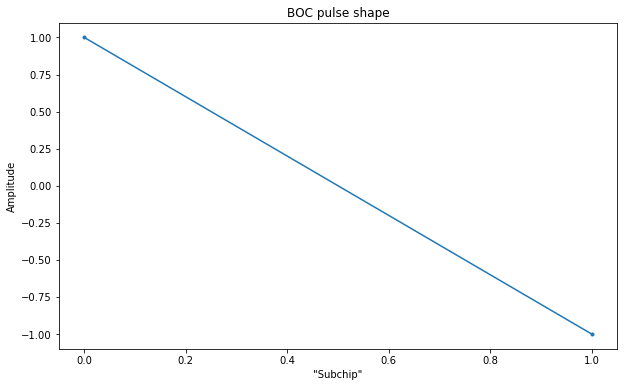

In [5]:
boc = np.tile([1,-1], boc_order)
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(boc, '.-')
plt.title('BOC pulse shape')
plt.xlabel('"Subchip"')
plt.ylabel('Amplitude');

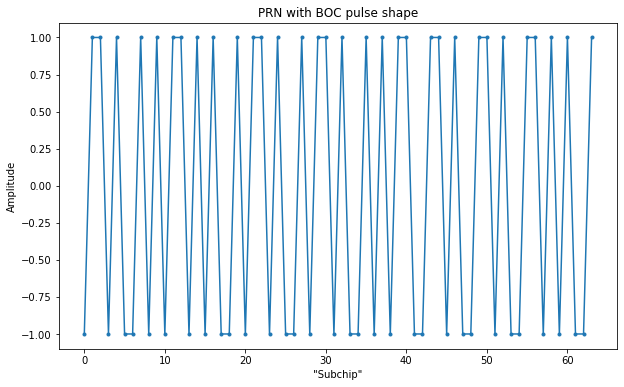

In [6]:
prn_subchips = np.repeat(prn, boc.size) * np.tile(boc, prn.size)
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(prn_subchips[:64], '.-')
plt.title('PRN with BOC pulse shape')
plt.xlabel('"Subchip"')
plt.ylabel('Amplitude');

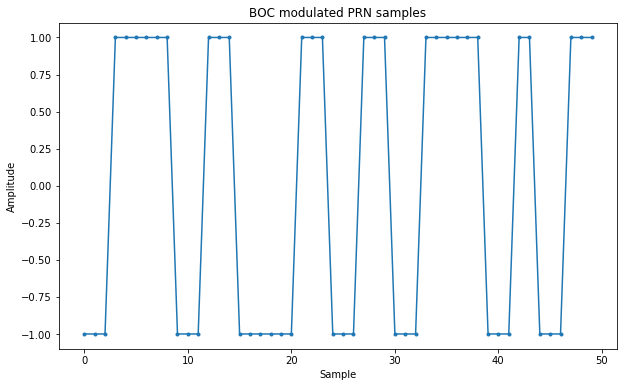

In [7]:
subchip_idx = np.int32(np.arange(N) * boc.size * fc / fs) % prn_subchips.size
x = prn_subchips[subchip_idx]
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(x[:50], '.-')
plt.title('BOC modulated PRN samples')
plt.xlabel('Sample')
plt.ylabel('Amplitude');

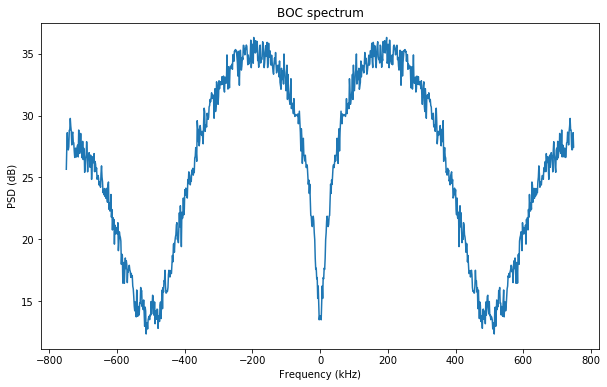

In [8]:
N_fft = 2**10
psd = 10*np.log10(np.fft.fftshift(np.average(np.abs(np.fft.fft(x[:x.size//N_fft*N_fft].reshape((-1,N_fft))))**2, axis = 0)))
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(np.fft.fftshift(np.fft.fftfreq(N_fft, 1/fs)) * 1e-3, psd)
plt.title('BOC spectrum')
plt.xlabel('Frequency (kHz)')
plt.ylabel('PSD (dB)');
plt.plot();

In [9]:
h = scipy.signal.firwin(51, 0.95 * bw / fs)
y = scipy.signal.lfilter(h, 1, x)[h.size//2:][N//3:2*N//3]

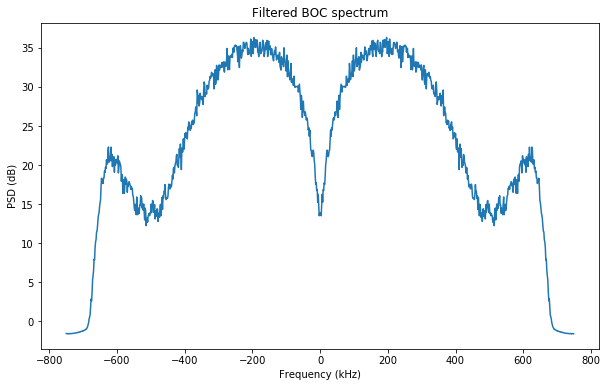

In [10]:
psd = 10*np.log10(np.fft.fftshift(np.average(np.abs(np.fft.fft(y[:y.size//N_fft*N_fft].reshape((-1,N_fft))))**2, axis = 0)))
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(np.fft.fftshift(np.fft.fftfreq(N_fft, 1/fs)) * 1e-3, psd)
plt.title('Filtered BOC spectrum')
plt.xlabel('Frequency (kHz)')
plt.ylabel('PSD (dB)');
plt.plot();

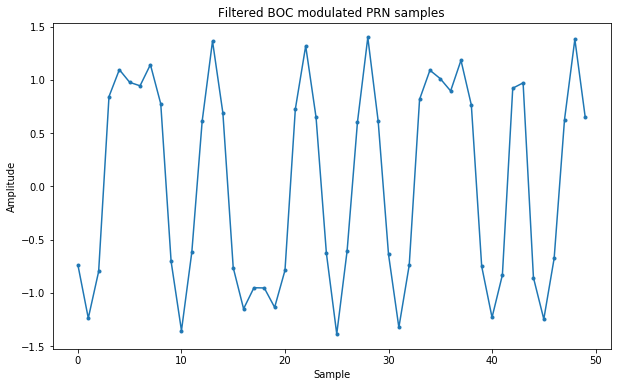

In [11]:
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(y[:50], '.-')
plt.title('Filtered BOC modulated PRN samples')
plt.xlabel('Sample')
plt.ylabel('Amplitude');

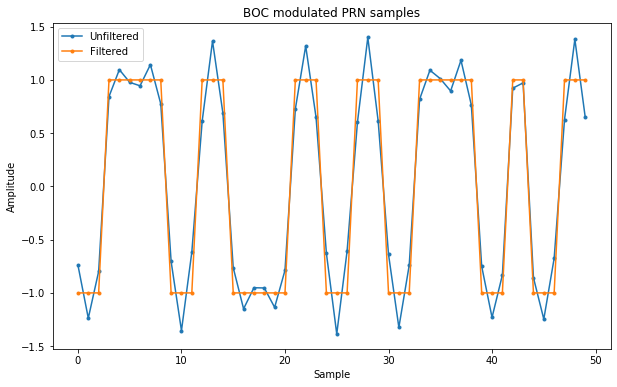

In [12]:
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(y[:50], '.-')
plt.plot(x[:50], '.-')
plt.title('BOC modulated PRN samples')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend(['Unfiltered', 'Filtered']);

In [13]:
delta = np.linspace(-1.2, 1.2, 1000)
corr_unfilt = np.empty(delta.size)
corr_filt = np.empty(delta.size)
for j, d in enumerate(delta):
    r = prn_subchips[np.int32(np.arange(N) * boc.size * fc / fs + d * boc.size) % prn_subchips.size]
    corr_unfilt[j] = np.average(x * r)
    corr_filt[j] = np.average(y * r[:y.size])

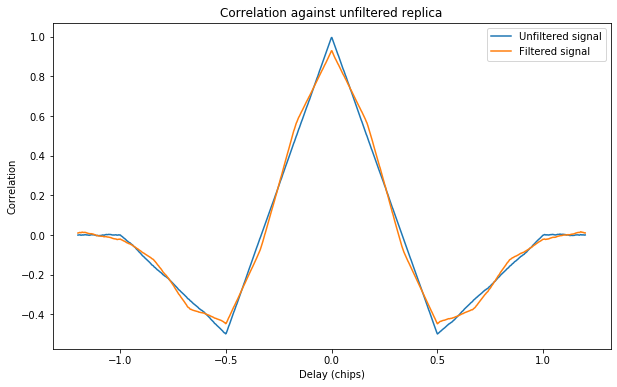

In [14]:
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(delta, corr_unfilt)
plt.plot(delta, corr_filt)
plt.title('Correlation against unfiltered replica')
plt.xlabel('Delay (chips)')
plt.ylabel('Correlation')
plt.legend(['Unfiltered signal', 'Filtered signal']);

In [15]:
M = np.max(np.abs(y))
y_i16 = np.zeros(2*y.size, dtype = 'int16')
y_i16[::2] = np.round(y / M * (2**15 - 1))
y_i16.tofile('tx_signal.int16')